In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import time
from sklearn.calibration import calibration_curve
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from sklearn.metrics import ndcg_score
from sklearn.metrics import top_k_accuracy_score
from scipy import sparse
from sys import getsizeof

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import warnings

In [2]:
def effectivity_at_top_k(y_true, y_pred, k=1):
    return np.mean(y_true[np.argsort(y_pred)[::-1][:k]])

In [3]:
def totriplets(df, addzeros=0):
    T = []
    maxj = np.max(df.jobseeker_index)
    maxv = np.max(df.vacancy_index)
    for i in range(len(df)):
        for j in range(2, len(df.columns)):
            if ~np.isnan(df.iloc[i,j]):
                T.append([df.iloc[i,0], df.iloc[i,1], j-2, df.iloc[i,j]])
        for zeros in range(addzeros):
            T.append([np.random.choice(maxj), df.iloc[i,1],  0, 0])
    return np.asarray(T, int)

    
def readdata(file):
    df = pd.read_csv(file)
    df = df.replace(-1,0) #only 1-0 features.
    df_train, df_test = train_test_split(df, test_size=0.2)
    res = totriplets_train(df_train)
    return res

In [4]:
df = pd.read_csv("../DataPreprocessing/VDAB_monotone_labels")
Xj = np.loadtxt("../DataPreprocessing/VDAB_features_jobseekers")
Xv = np.loadtxt("../DataPreprocessing/VDAB_features_vacancies")
print(df.shape, Xj.shape, Xv.shape)
df

(82460, 6) (17239, 16) (42577, 16)


,jobseeker_index,vacancy_index,CLICKS_BINARY,SOLLICITATIE,INTERVIEW,HIRED
0,13606,7541,1,NaN,NaN,NaN
1,13606,13738,1,1.0,1.0,1.0
2,13606,15849,1,NaN,NaN,NaN
3,13606,22264,1,NaN,NaN,NaN
4,9468,2877,1,NaN,NaN,0.0
...,...,...,...,...,...,...
82455,9357,33486,1,1.0,0.0,0.0
82456,9357,37213,1,1.0,1.0,0.0
82457,9357,41673,1,NaN,NaN,NaN
82458,9357,42349,1,NaN,NaN,NaN


In [5]:
# split into train and test

test_size=0.1

df_train, df_test = train_test_split(df, test_size=test_size,random_state=2)

In [6]:
# add random zero samples for the implicit clicks
def addzeros(df_):
    df__ = copy.deepcopy(df_)
    shuffled = np.array(df__['vacancy_index'])
    np.random.shuffle(shuffled)
    df__['vacancy_index'] = shuffled
    df__['CLICKS_BINARY']=0
    df__[['SOLLICITATIE','INTERVIEW','HIRED']]=0
    return df_.append(df__)

In [7]:
Y_train = np.asarray(addzeros(df_train))
Y_test = np.asarray(addzeros(df_test))

In [8]:
df__ = addzeros(df)
print(np.nanmean(df__.iloc[:,2:]))
df__ = df__.replace(np.nan, '?')

0.23500587210950472


In [9]:
np.sum(df__.CLICKS_BINARY)

82460

In [11]:
aaa = df__.fillna('?')[['CLICKS_BINARY','SOLLICITATIE','INTERVIEW', 'HIRED']].groupby(['CLICKS_BINARY','SOLLICITATIE','INTERVIEW', 'HIRED'], as_index=False).size()
aaa['size']=aaa['size']/np.sum(aaa['size'])
aaa

,CLICKS_BINARY,SOLLICITATIE,INTERVIEW,HIRED,size
0,0,0,0,0,0.500000
1,1,0,0,0,0.049715
2,1,1,0,0,0.150230
3,1,1,1,0,0.029087
4,1,1,1,1,0.021902
5,1,?,0,0,0.000928
6,1,?,?,0,0.039340
7,1,?,?,?,0.208798


In [16]:
def pr_auc_score(true, pred, r=None):
    lr_precision, lr_recall, _ = precision_recall_curve(true, pred)
    if r is not None:
        r_ = (1/np.nanmean(true))-1  # ratio negatives/positives
        r_ = len(true[true==0])/len(true[true==1])  # ratio negatives/positives
        
        print(r,r_)
        lr_precision = lr_precision/(lr_precision+r/r_*(1-lr_precision))
    return auc(lr_recall, lr_precision)

def metric_(true, pred, metric): #metrics such as auc throw error in case of one class available.
    if metric==ndcg_score:
        true=[true]
        pred=[pred]
    #return metric(true, pred)
    try:
        warnings.filterwarnings("ignore")
        return metric(true, pred)
    except:
        warnings.filterwarnings("default")
        return np.nan

def evaluate_per_row(true, pred, metric):
    return np.nanmean([metric_(true[i,:][~np.isnan(true[i,:])], pred[i,:][~np.isnan(true[i,:])],metric) for i in range(true.shape[0])])
def evaluate_per_column(true, pred, metric):
    return evaluate_per_row(true.transpose(), pred.transpose(), metric)

def evaluate_direct(Y_test, P):
    resprflat = []
    resprperrow = []
    resndcgperrow =[]
    for stage in range(4):
        true, pred = copy.deepcopy(Y_test[:,stage]), copy.deepcopy(P[:,stage])
        
        #prflat = pr_auc_score(true[~np.isnan(true)], pred[~np.isnan(true)], r=1/0.307)
        prflat = roc_auc_score(true[~np.isnan(true)], pred[~np.isnan(true)])
        resprflat.append(prflat)
  
    
    print('resprflat')
    print("& {:.2} & {:.2} & {:.2} & {:.2}  \\\\".format(resprflat[0],resprflat[1],resprflat[2],resprflat[3]))
    

def evaluate_conditional(Y_test, P):
    resprflat = []
    resprperrow = []
    resndcgperrow =[]    
    for stage in range(1,4):
        true, pred = copy.deepcopy(Y_test[:,stage]), copy.deepcopy(P[:,stage]/P[:,stage-1])
        prev = copy.deepcopy(Y_test[:,stage-1])
        
        true[prev==0]=np.nan
        pred[prev==0]=np.nan

        
        #prflat = pr_auc_score(true[~np.isnan(true)], pred[~np.isnan(true)],r=1/0.307)
        prflat = roc_auc_score(true[~np.isnan(true)], pred[~np.isnan(true)])
        resprflat.append(prflat)

        
    print('resprflat')
    print("& {:.2} & {:.2} & {:.2}  \\\\".format(resprflat[0],resprflat[1],resprflat[2]))

    


In [17]:
def outersum(a,b):
    return np.outer(a, np.ones(len(b))) + np.outer(np.ones(len(a)), b)

def maxoutersum(a,b,inds, α):
    return np.log(np.exp(α*a[inds[:,0]]) + np.exp(α*b[inds[:,1]]))/α

def maxoutersum_deriv(a,b,inds, α):
    D = 1./maxoutersum(a,b,inds, α)
    return outersum(D,np.exp(α*a)) #).transpose(), D*np.exp(α*b)

def maxoutersum_deriv(a,b,inds, α):
    common = 1./(np.exp(α*a[inds[:,0]]) + np.exp(α*b[inds[:,1]]))    #\alpha drops with second factor in next lines
    Da = sparse.csr_matrix((common*np.exp(α*a[inds[:,0]]), (range(len(inds)), inds[:,0])), shape=(len(inds),len(a)))
    Db = sparse.csr_matrix((common*np.exp(α*b[inds[:,1]]), (range(len(inds)), inds[:,1])), shape=(len(inds),len(b)))
    return Da, Db

In [18]:
def visualizeprogression(m, Ltrain, Lval, R):
    global Iter
    try:
        m.neval.append(m.neval[-1]+1)
        m.niter.append(Iter)
        m.Ltrain.append(Ltrain)
        m.R.append(R)
        m.Lval.append(Lval)
        
    except:
        # for the first loss evaluation. First evaluation corresponds loss after 0 iterations. After that. Iter is set to 1.
        m.Ltrain.append(Ltrain)
        m.R.append(R)
        m.Lval.append(Lval)
        
        Iter=0
        m.niter.append(Iter)
        Iter=1
        m.neval.append(1) 
    
    plt.figure()
    xx = pd.DataFrame()
    xx['niter']=np.array(m.niter)
    xx['norm']=np.array(m.R)
    xx['Lval']=np.array(m.Lval)
    xx['Ltrain'] = m.Ltrain
    xx = xx.groupby('niter', as_index=False).min() #if multiple function evaluations at same iteration
    plt.plot(xx.niter, xx.Ltrain/xx.Ltrain[0], label='L',c='k')
    plt.plot(xx.niter, xx.Lval/xx.Lval[0], label='Lval',c='k',linestyle='dashed')
    #try:
    #    plt.plot(xx.niter, xx.norm/xx.norm[len(xx.norm)-1], label='norm')
    #except:
    #    print(xx.norm)
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.savefig('optimization_synthetic')
    plt.close()
    
    print(Iter, Ltrain, R, Lval)

In [19]:
# x is logit, z is label
def sigmoidcrossentropy(x,z):#,β):
    #x = β*x
    ma = np.zeros(x.shape)
    ma[x>0]=x[x>0]
    return ma - x*z + np.log(1+np.exp(-abs(x)))
def sigmoidcrossentropy_deriv(x,z):#,β):
    #x = β*x
    res = np.zeros(x.shape)
    res[x>=0] = (1 - z - 1./(1+np.exp(-x))*np.exp(-x))[x>=0]
    res[x<0] = (-z + 1/(1+np.exp(x))*np.exp(x))[x<0]
    return res
def Epos(f, θ=1):
    res =  np.log(1+np.exp(θ*f))/θ
    res[(θ*f)>100]=f[(θ*f)>100]   #if overflow
    return res
def Epos_deriv(f, θ=1):
    res = np.exp(θ*f)/(1+np.exp(θ*f))
    res[(θ*f)>100]=1  #if overflow
    return res

def expcrossentropy(f,y):#,β):
    #f = β*f
    f=f+1e-15
    assert f.all()>0
    return y*f -(1-y)*np.log(1-np.exp(-f))

def expcrossentropy_deriv(f,y):#,β):
    #f = β*f
    f=f+1e-15
    assert f.all()>0
    return y - (1-y)/(1-np.exp(-f))*np.exp(-f)

In [20]:
def outersum_full(a,b):
    return np.outer(a, np.ones(len(b))) + np.outer(np.ones(len(a)), b)

def maxoutersum_full(a,b,α):
    return np.log(outersum_full(np.exp(α*a), np.exp(α*b)))/α

In [21]:
def predict(A, th1, th2, α,β, K1, K2,inds=None):
    
    if inds is not None:
        f = β*(np.einsum('uv,nu,nv->n',A,K1[inds[:,0],:],K2[inds[:,1],:],optimize='greedy') + maxoutersum(th1, th2, inds,α))
    else:
        a = time.time()
        res =  β*(np.matmul(np.matmul(K1, A),K2.transpose()) + maxoutersum_full(th1, th2,α))
        b = time.time()
        print(b-a)
        return res
    
    #f = β*(np.matmul(np.matmul(K1, A),K2.transpose()) + maxoutersum(th1, th2, α))
    return f


def loss_deriv_(A_,K1,K2,Ytrain,Yval, m):
    if m.version == sigmoidcrossentropy:
        print('not implemented')
        return 'not implemented'
        #DLDF = np.nan_to_num(sigmoidcrossentropy_deriv(f,Ytrain,m.β), nan=0)/len(np.where(~np.isnan(Ytrain))[0]) #if no label is nan, contribution to deriv is zero
    elif m.version ==  expcrossentropy:
        A = A_[:m.A.size].reshape(m.A.shape)
        th1 = A_[m.A.size:m.A.size+m.th1.size].reshape(m.th1.shape)
        th2 = A_[m.A.size+m.th1.size:m.A.size+m.th1.size+m.th2.size].reshape(m.th2.shape)
        β =  A_[m.A.size+m.th1.size+m.th2.size:]
        #f = predict(A, th1, th2, m.α, K1, K2)
        E = np.zeros((Ytrain.shape[0], Ytrain.shape[1]-2))
        for stage in range(E.shape[1]):
            E[:,stage] = predict(A[:,:,stage], th1[:,stage], th2[:,stage],m.α, β[stage],K1, K2,Ytrain[:,:2].astype(int))
        Ep = Epos(E)
        F = np.cumsum(Ep, axis=1)

        DLDF = (np.nan_to_num(expcrossentropy_deriv(F,Ytrain[:,2:]), nan=0)/len(np.where(~np.isnan(Ytrain))[0])) #if no label is nan, contribution to deriv is zero
        #DLDEp = np.cumsum(np.flip(DLDF,axis=2),axis=2)
        DLDEp = np.flip(np.cumsum(np.flip(DLDF,axis=1),axis=1),axis=1)
        DLDE = DLDEp*Epos_deriv(E)
        
                
        DLDA = np.zeros(A.shape)
        DLDTH1 = np.zeros(th1.shape)
        DLDTH2 = np.zeros(th2.shape)
        DLDβ = np.zeros(β.shape)
        for stage in range(E.shape[1]):
            DLDA[:,:,stage] = β[stage]*np.einsum('n,nu,nv->uv',DLDE[:,stage],K1[Y_train[:,0].astype(int),:],K2[Y_train[:,1].astype(int),:],optimize='greedy')
            
            
            DEDTH1, DEDTH2 = maxoutersum_deriv(th1[:,stage],th2[:,stage],Ytrain[:,:2].astype(int), m.α)
            #print(th1.shape,th2.shape)
            #print(DEDTH1.shape, DEDTH2.shape)
            
            DLDTH1[:,stage] = β[stage]*sparse.csr_matrix.dot(DLDE[:,stage], DEDTH1) #β[stage]*
            DLDTH2[:,stage] = β[stage]*sparse.csr_matrix.dot(DLDE[:,stage], DEDTH2) #β[stage]*
            
            DLDTH1[:,stage] += Lth1_[stage] * 2* th1[:,stage]
            DLDTH2[:,stage] += Lth2_[stage] * 2* th2[:,stage]
            
            if m.varβ:
                DLDβ[stage] = np.sum(DLDE[:,stage]*E[:,stage]/β[stage])
            
                DLDβ[stage]+=Lbeta_[stage]*2*β[stage]

        DRDA = m.λ*2*A/A.size

        
        
        if m.competition:
            return np.concatenate([(DLDA+DRDA).flatten(),DLDTH1.flatten(), DLDTH2.flatten(),DLDβ])
        else:
            return np.concatenate([(DLDA+DRDA).flatten(),np.zeros(DLDTH1.size), np.zeros(DLDTH2.size),DLDβ])
    else:
        print('not implemented')
        return 'not implemented'

    
def loss_(A_,K1,K2,Ytrain,Yval, m):
    if m.version == sigmoidcrossentropy:
        print('not implemented')
        return 'not implemented'
        #L_train = np.nanmean(sigmoidcrossentropy(f, Ytrain,m.β)) #nan if label is not training label
        #L_val = np.nanmean(sigmoidcrossentropy(f, Yval,m.β))

    elif m.version ==  expcrossentropy:
        A = A_[:m.A.size].reshape(m.A.shape)
        th1 = A_[m.A.size:m.A.size+m.th1.size].reshape(m.th1.shape)
        th2 = A_[m.A.size+m.th1.size:m.A.size+m.th1.size+m.th2.size].reshape(m.th2.shape)
        β =  A_[m.A.size+m.th1.size+m.th2.size:]
        #f = predict(A, th1, th2, m.α, K1, K2)
        
        # training
        E = np.zeros((Ytrain.shape[0], Ytrain.shape[1]-2))
        for stage in range(E.shape[1]):
            E[:,stage] = predict(A[:,:,stage], th1[:,stage], th2[:,stage],m.α, β[stage],K1, K2,Ytrain[:,:2].astype(int))
            #print(np.sqrt(np.mean(E[:,stage]**2)))
        Ep = Epos(E)
        F = np.cumsum(Ep, axis=1)
        L_train = np.nanmean(expcrossentropy(F, Ytrain[:,2:])) #nan if label is not training label   

        for i in range(Ytrain.shape[1]-2):
            xxx_train[i].append(np.nanmean(expcrossentropy(F[:,i], Ytrain[:,2+i])))
        
        # validation
        E = np.zeros((Yval.shape[0], Yval.shape[1]-2))
        for stage in range(E.shape[1]):
            E[:,stage] = predict(A[:,:,stage], th1[:,stage], th2[:,stage],m.α, β[stage],K1, K2,Yval[:,:2].astype(int))
        Ep = Epos(E)
        F = np.cumsum(Ep, axis=1)
        L_val = np.nanmean(expcrossentropy(F, Yval[:,2:])) #nan if label is not training label        
                
        
        R = m.λ*np.sum(A*A)/A.size
        m.A[:]=A[:] 
        m.th1[:]=th1[:]
        m.th2[:]=th2[:]
        m.β[:]=β
        
        for i in range(Ytrain.shape[1]-2):
            xxx_val[i].append(np.nanmean(expcrossentropy(F[:,i], Yval[:,2+i])))
        
        visualizeprogression(m, L_train, L_val, R)
        
        plt.figure()
        plt.plot(xxx_val[0]/xxx_val[0][0],c='y')
        plt.plot(xxx_val[1]/xxx_val[1][0],c='r')
        plt.plot(xxx_val[2]/xxx_val[2][0],c='b')
        plt.plot(xxx_val[3]/xxx_val[3][0],c='k')
        plt.yscale("log")
        plt.xscale("log")
        plt.savefig("test_independent")
        plt.close()
        
        Lbeta = np.sum(Lbeta_ * m.β**2)
        Lth = np.sum(Lth1_ * np.sum(th1**2,axis=0)) + np.sum(Lth2_ * np.sum(th2**2,axis=0))

        return L_train + R + Lbeta + Lth
    else:
        print('not implemented')
        return 'not implemented'

def callback(A):
    global Iter
    Iter+=1

Iter=0

class Model_():
    def __init__(self, λ, competition, version, α, varβ):
        self.λ=λ
        self.A=0
        self.competition=competition
        self.version=version
        self.α=α
        self.varβ=varβ
        self.neval, self.niter, self.Ltrain,self.R,self.Lval= [],[],[],[],[]
        global Iter
        Iter = 0

        
    
    def fit(self,K1,K2,Ytrain,Yval=None, maxiter=20):
        if type(self.A) != int:
            global Iter
            Iter = self.niter[-1]
            print("Continuing with current model parameters.")
            #res = minimize(fun=loss,x0=np.concatenate([self.A.flatten(), self.th1.flatten(), self.th2.flatten()]), args=(K1,K2,Ytrain,Yval,self), jac=loss_deriv, method='L-BFGS-B', options ={'maxiter':maxiter,'ftol': 0, 'gtol': 0}, callback=callback)
        else:
            A0=np.zeros((K1.shape[1], K2.shape[1],Ytrain.shape[1]-2))
            th1 = np.zeros((K1.shape[0],Ytrain.shape[1]-2))
            th2 = np.zeros((K2.shape[0],Ytrain.shape[1]-2))
            β = np.ones(Ytrain.shape[1]-2)
            self.A=A0
            self.th1 = th1
            self.th2 = th2
            self.β=β
            print("New model parameters initialized as zeros.")

        res = minimize(fun=loss_,x0=np.concatenate([self.A.flatten(), self.th1.flatten(), self.th2.flatten(),self.β]), args=(K1,K2,Ytrain,Yval,self), jac=loss_deriv_, method='L-BFGS-B', options ={'maxiter':maxiter,'ftol': 0, 'gtol': 0}, callback=callback)
        A_ = res.x
        self.A = A_[:self.A.size].reshape(self.A.shape)
        self.th1 = A_[self.A.size:self.A.size+self.th1.size].reshape(self.th1.shape)
        self.th2 = A_[self.A.size+self.th1.size:self.A.size+self.th1.size+self.th2.size].reshape(self.th2.shape)
        self.β = A_[self.A.size+self.th1.size+self.th2.size:]
        return res
        
    def predict_proba(self, K1,K2,Ytest,th=True): #argumement Ytest to now which predictions to return
        if self.version == sigmoidcrossentropy:
            print('not implemented')
            return 'not implemented'
        elif self.version ==  expcrossentropy:
            
            
            E = np.zeros((Ytest.shape[0], Ytest.shape[1]-2))
            for stage in range(E.shape[1]):
                E[:,stage] = predict(self.A[:,:,stage], self.th1[:,stage], self.th2[:,stage],self.α, self.β[stage],K1, K2,Ytest[:,:2].astype(int))
            Ep = Epos(E)
            F = np.cumsum(Ep, axis=1)
            return np.exp(-F)

            """
            E = np.zeros((K1.shape[0],K2.shape[0],self.A.shape[2]))
            print(self.A.shape, self.A.shape[2], E.shape)
            for stage in range(E.shape[2]):
                #print(stage)
                E[:,:,stage] = predict(self.A[:,:,stage], self.th1[:,stage], self.th2[:,stage],self.α,self.β[stage], K1, K2)
            c = time.time()
            Ep = Epos(E)
            d = time.time()
            print(d-c)
            F = np.cumsum(Ep, axis=2)
            e = time.time()
            print(e-d)
            return np.exp(-F)
            """
        else:
            print('not implemented')
            return 'not implemented'

    


In [23]:
Y_train.shape

(148428, 6)

In [24]:
Xv.shape

(42577, 16)

In [ ]:
# regularization on beta and the thresholds
Lbeta_ = [0,0,0,0]
Lth1_ =  [0,0,0,0]
Lth2_ = [0,0,0,0]

In [ ]:
# model with competition activation function

xxx_val = [[],[],[],[]]
xxx_train =  [[],[],[],[]]

a=time.time()
model1_=Model_(λ=0, competition=False, version=expcrossentropy,α=10, varβ=False)
res = model1_.fit(Xj,Xv,Y_train,Y_test,maxiter=2000)
b=time.time()
print("duration of trainig", b-a)
print(res.success, res.message)


New model parameters initialized as zeros.


/opt/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 0.43526165256534016 0.0 0.43744299211028537


/opt/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 2.824582091434359 0.0 2.8340136362344794
1 0.58637519633082 0.0 0.5925872202633626
1 0.40876947986420353 0.0 0.4104995025204983
2 0.3964548970202482 0.0 0.39852737659724485
3 0.3923600893741016 0.0 0.3943964734011898
4 0.3835941441557191 0.0 0.38553946665487876
5 0.3804673568443249 0.0 0.3822335989711335
6 0.37718399854653395 0.0 0.3793607482609432
7 0.37377236369270295 0.0 0.3764892418933207
8 0.3717283556361692 0.0 0.37458782423915993
9 0.3695345147587471 0.0 0.3729030235421796
10 0.3668179887206401 0.0 0.3698295382025523
11 0.3659032116466065 0.0 0.3687985863155094
12 0.36421014000753843 0.0 0.3669238701854993
13 0.3631827135523931 0.0 0.36586340869825545
14 0.36221180963875493 0.0 0.36497376987315333
15 0.3615904205204336 0.0 0.364447774772381
16 0.36094280062886996 0.0 0.3639167078300912
17 0.3604665484349758 0.0 0.3634738334591727
18 0.36001838186177076 0.0 0.3629930473475549
19 0.3595650504215681 0.0 0.3624608750659261
20 0.3592732064706319 0.0 0.3622514301907683
21 0.35896022

171 0.3558480381389785 0.0 0.36060704891524153
172 0.3558457780491776 0.0 0.3606184620439297
173 0.3558452455902075 0.0 0.3606196475183061
174 0.3558439655894455 0.0 0.36062608828344445
175 0.3558420574369716 0.0 0.36063352778802765
176 0.3558407236118925 0.0 0.3606508982642099
177 0.35583933537975354 0.0 0.36064736729681024
178 0.3558386045843381 0.0 0.3606459784914486
179 0.35583749466578113 0.0 0.3606421427668968
180 0.35583661430944125 0.0 0.3606563271653125
181 0.3558353214952822 0.0 0.3606515326690236
182 0.35583441458608206 0.0 0.36065062680165455
183 0.3558335259678058 0.0 0.3606523292256523
184 0.355832462361998 0.0 0.36065715265985054
185 0.3558309874300158 0.0 0.3606551338705212
186 0.35583020162777274 0.0 0.36065550073476005
187 0.3558295093004402 0.0 0.3606534016058097
188 0.3558286200505113 0.0 0.3606578981910485
189 0.3558277043762493 0.0 0.36065571182370604
190 0.35582652483959276 0.0 0.3606540493274082
191 0.3558259771977998 0.0 0.3606587969150708
192 0.355825123754037

336 0.35573123837720627 0.0 0.3608328621088837
337 0.35573084661141946 0.0 0.3608352408313676
338 0.35573050699215253 0.0 0.36083693135273254
339 0.3557303330576875 0.0 0.36084823817866296
340 0.355729759321369 0.0 0.3608435392450038
341 0.3557295421800791 0.0 0.3608425912413259
342 0.3557293151099405 0.0 0.3608432321634168
343 0.3557289300555256 0.0 0.3608452299687579
344 0.35572823078247673 0.0 0.3608423322412902
345 0.3557276696591285 0.0 0.3608546936075392
346 0.35572725224276197 0.0 0.3608503008971009
347 0.3557269534520495 0.0 0.36084653161539004
348 0.35572669288113645 0.0 0.36084525952378693
349 0.35572628048501864 0.0 0.360840609999481
350 0.355725808929378 0.0 0.36084417646949357
351 0.3557255333447253 0.0 0.3608473473810581
352 0.3557251809706266 0.0 0.36085148385065824
353 0.35572476842436623 0.0 0.36085723211928183
354 0.35572430541710637 0.0 0.3608588345397544
355 0.35572394455506734 0.0 0.3608577864627329
356 0.355723616428873 0.0 0.3608525364595759
357 0.355723458906487

505 0.3556727133991184 0.0 0.3609615058163851
506 0.3556724718568069 0.0 0.36096309626731204


In [ ]:
# model with competition activation function

xxx_val = [[],[],[],[]]
xxx_train =  [[],[],[],[]]

a=time.time()
model3_=Model_(λ=1e0, competition=True, version=expcrossentropy,α=10, varβ=True)
res = model3_.fit(Xj,Xv,Y_train,Y_test,maxiter=7000)
b=time.time()
print("duration of trainig", b-a)
print(res.success, res.message)


New model parameters initialized as zeros.


/opt/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 0.43526165256534016 0.0 0.43744299211028537


/opt/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 2.821724627408857 0.000976562446172783 2.7963680722299236
1 0.5858788921103053 1.4122115597886899e-05 0.5842799486835693
1 0.4087505021602983 5.302632322573224e-07 0.40910716784907236
2 0.3965511264390373 8.856394041856122e-07 0.3976656076631383
3 0.3924188003297939 9.569417458223924e-07 0.39341666870930614
4 0.3837527345876981 1.768584859180751e-06 0.38402161793400974
5 0.38047740943984387 2.4945006470276056e-06 0.3806786411689591
6 0.37723932014175743 2.92337058815482e-06 0.3775490216303037
7 0.3737882285724475 4.37529147079744e-06 0.37421090733373663
8 0.37170197290522494 5.517626795136988e-06 0.3721652814184734
9 0.3704472003475161 9.118374012319326e-06 0.3716135454030391
10 0.36722645754108507 9.858042382712072e-06 0.36811712346926784
11 0.3664087284752821 9.872759894912592e-06 0.3672045686568548
12 0.3647987858230902 1.1201650498065518e-05 0.3655732464963934
13 0.36343600517007424 1.3451678224219506e-05 0.3641682905780359
14 0.36319203898045294 1.9114016157496958e-05 0.36458088

123 0.3562806682690843 5.4900076552787654e-05 0.36014115628650506
123 0.3562767222969827 5.4475230549885765e-05 0.36011384384091305
124 0.3562734349651786 5.478986971839731e-05 0.3601119434162209
125 0.3562705233213841 5.500180604152744e-05 0.36010520663507434
126 0.35626673586144164 5.5403338152141486e-05 0.3600991573264354
127 0.3562647833524752 5.557733642423905e-05 0.3600877143434884
128 0.35626352176657927 5.558296785310686e-05 0.3600910197813461
129 0.3562610685189662 5.5717301007897e-05 0.3601020744574651
130 0.35625944940912163 5.589327645677354e-05 0.36010694494041534
131 0.35625718792461364 5.63326878084847e-05 0.3601269623339152
132 0.35625538892592706 5.644020943833827e-05 0.3601228350613662
133 0.35625428274931953 5.6455195107092795e-05 0.36011841002831857
134 0.35625290166400647 5.6553307399737486e-05 0.36011987831178816
135 0.35625224889960005 5.668179404184071e-05 0.3601210901632813
136 0.3562497248830063 5.676412264300132e-05 0.36012441944727724
137 0.35624849225659944

243 0.3560633406929856 7.951669308328783e-05 0.3602816617868818
244 0.35606260963302416 7.946513792452811e-05 0.3602723878855088
245 0.356062109086567 7.941599811679635e-05 0.3602658442022114
246 0.3560609232044052 7.950783554429189e-05 0.3602598296100767
247 0.3560587644120789 7.987633522521599e-05 0.3602545582098135
248 0.3560598949894609 8.052369454013535e-05 0.36024951825210577
248 0.3560578178001026 8.00477345906554e-05 0.3602519660523066
249 0.35605628655833127 8.044013586526676e-05 0.36025195105859803
250 0.3560549881462724 8.072890504491463e-05 0.3602495389878924
251 0.35605359774465695 8.109966999553085e-05 0.36024006196340186
252 0.35605268496864445 8.114165453602685e-05 0.36023294569011843
253 0.3560522022405906 8.10597442481481e-05 0.36022901979470867
254 0.3560514726169567 8.09656297760467e-05 0.36022223123700853
255 0.3560520296186624 8.133766724687992e-05 0.36022088179489725
255 0.35605098375208133 8.106321599560772e-05 0.36022123864703987
256 0.3560502188533137 8.117341

364 0.35598376815053023 8.956806720878688e-05 0.3602098839169612
365 0.3559829516691279 8.972117743724044e-05 0.36021682890476703
366 0.35598250772568113 8.989412357739526e-05 0.3602121721813461
367 0.35598232416663794 8.986085241790949e-05 0.3602146586631604
368 0.35598208727906105 8.985075737164304e-05 0.3602170483923159
369 0.35598173951449213 8.988823460936846e-05 0.36021935083426737
370 0.3559810672065342 9.001300308986767e-05 0.3602220374802749
371 0.3559824159106442 9.037591780288034e-05 0.36023279290878885
371 0.3559808739032268 9.005807970764537e-05 0.3602230332111962
372 0.35598013526196165 9.025598161342634e-05 0.36022475978176866
373 0.35597954877399207 9.038917571061868e-05 0.3602263126051566
374 0.3559787450169336 9.061726625162808e-05 0.36022577230243724
375 0.3559782938498414 9.071869579522511e-05 0.3602309946597599
376 0.35597820173175515 9.066106060066863e-05 0.3602302293219323
377 0.3559779721788524 9.061349179138987e-05 0.3602307843351316
378 0.35597770125115447 9.0

481 0.35591556217638753 0.0001076968611010989 0.3603137700154474
482 0.35591494123304257 0.00010794080936488319 0.36031409123186015
483 0.35591440200060537 0.00010805698083460918 0.36031021172706656
484 0.3559138561303733 0.00010823503259104169 0.3603099075350435
485 0.3559133919795426 0.00010840295025833001 0.36031179672912633
486 0.35591238955773336 0.00010876437338371226 0.3603193421189025
487 0.3559111861384758 0.00010931191494700286 0.360325857646648
488 0.3559110042485791 0.00010925026938065599 0.3603262152969769
489 0.3559108313033246 0.00010923923174243991 0.36032608528020726
490 0.35591052385384386 0.00010931892195488765 0.3603260805068792
491 0.3559097423834869 0.00010970755091909825 0.360325027177786
492 0.3559090349196225 0.00010984823105624058 0.36032673612866745
493 0.35590870576895073 0.00010994777862153343 0.3603277583853273
494 0.3559081549846241 0.00011013962830562295 0.36033019667833577
495 0.35590749884911926 0.00011035243887811276 0.36033469597558354
496 0.35590731

599 0.3558344320894967 0.0001282433193789603 0.36038477398476476
600 0.3558338621715324 0.00012833584954528935 0.360384681733531
601 0.35583260673169964 0.00012865543136932362 0.3603849723205124
602 0.35583198785564346 0.00012910924792649246 0.36038222543636733
602 0.35583192691204596 0.00012886521741779317 0.3603833084188073
603 0.3558314796614649 0.00012895936508030767 0.36038218957801404
604 0.3558297832062468 0.00012940964688585834 0.360373870890092
605 0.3558294934697305 0.00012969008386099227 0.3603750053740532
605 0.35582930435704135 0.00012953343718373784 0.36037401828040494
606 0.3558286093429221 0.00012972146411709096 0.36037027862658083
607 0.35582701923789306 0.00013012089880078947 0.3603625599577951
608 0.3558256425397656 0.00013049182510368586 0.360360762435376
609 0.3558242327179032 0.00013093733032582263 0.36035481266858527
610 0.3558235510905977 0.00013097530061688146 0.3603595385074045
611 0.3558227794556892 0.0001309972183233389 0.36036362593590543
612 0.355822012384

718 0.35564655587760285 0.00016817847307557275 0.3604655232979887
719 0.35564396622825806 0.00016867173243518204 0.36046824942909855
720 0.3556422742218197 0.00016901059945268284 0.3604694774934164
721 0.3556405923969355 0.00016934333002240634 0.3604687595215455
722 0.35563809491977144 0.00016996665408253598 0.36047722317983877
723 0.355635503160563 0.0001704225397282977 0.3604773093861892
724 0.35563311863618374 0.00017075629946189483 0.36048268482190204
725 0.3556308411598493 0.00017112690405430834 0.3604892635163364
726 0.35562893858972744 0.0001716013687021935 0.3605084642510799
727 0.3556269210373572 0.00017182218771458958 0.36050496861034803
728 0.355624412256693 0.00017218971395736182 0.36050226163737853
729 0.3556224224980212 0.00017257688188334187 0.3605023291274653
730 0.3556199807999299 0.00017341014999307748 0.3605039543042899
731 0.35561693408550554 0.00017360885756553893 0.3605067412282774
732 0.35561575688110786 0.00017369237457890707 0.3605093307223834
733 0.35561439977

836 0.35522449589348887 0.000197613016337455 0.36054627504176495
837 0.35521809958107237 0.0001975808190166577 0.36054176964346674
838 0.3552142185971453 0.00019757186500186168 0.3605390538248685
839 0.35520931063428207 0.0001975453196015776 0.36053731964174474
840 0.35520510104395925 0.00019750288141931824 0.3605238530973556
841 0.35519681240621676 0.00019735202281660072 0.36050207343531193
842 0.3551910442714401 0.00019724405603141314 0.3604721320737857
843 0.3551863589660533 0.00019722220217044902 0.3604669531415292
844 0.35518221895212443 0.00019717716800843153 0.36047364746092764
845 0.3551782689330004 0.00019711953530864457 0.36047707500414305
846 0.3551695394272993 0.00019693845173062718 0.3605140435178951
847 0.3551635567258827 0.0001968454137579465 0.36051612284321605
848 0.3551595380976955 0.00019680828403001923 0.3605158055974947
849 0.3551542276286495 0.00019673672895190007 0.36052708215995233
850 0.35514914954856497 0.00019668346430160147 0.3605247334322758
851 0.355143480

959 0.3540777095452475 0.000177152629789871 0.3600781619888511
960 0.3540646783138725 0.00017701556435760813 0.36005502621076424
961 0.35405162615656144 0.00017685981326994048 0.36008463053783607
962 0.3540382853705429 0.00017670232104265973 0.3601075557240161
963 0.3540042601686036 0.00017621476879026707 0.3601881393733559
964 0.3539961889334405 0.0001758472019220759 0.36028140754557836
965 0.35397073714038213 0.00017579075656073083 0.3602561179314256
966 0.3539574755752152 0.00017573271393755784 0.3602350015406009
967 0.35394565363559927 0.0001756173814314252 0.3602278754270046
968 0.353920959545937 0.00017539366691764956 0.36023581057589327
969 0.3539919332594813 0.00017488035700411627 0.3602919088621988
969 0.35391283311028543 0.00017531063355432096 0.3602256938452973
970 0.35389017738017253 0.0001750110218321323 0.3602670195012644
971 0.3538777999132767 0.00017478841118997779 0.36029203222780964
972 0.35385771914274533 0.00017468322010534315 0.360300506615605
973 0.353835854002154

1076 0.35129365617521224 0.00019397535070854617 0.359276096267436
1076 0.3512640460807883 0.00019374356251429336 0.3591958275993406
1077 0.35123813641438667 0.00019390362600901716 0.35920135157357014
1078 0.3512164826323968 0.00019395178628987814 0.35919672734485075
1079 0.3511795712678406 0.00019402580094219778 0.3592165262791061
1080 0.35118056548147947 0.00019423765941295582 0.35926238437275404
1080 0.35116306559959276 0.00019412677564454228 0.3592214699806459
1081 0.3511509714176774 0.00019414212364547576 0.35921703466352756
1082 0.3511255611712543 0.0001942552789851947 0.35923497754075295
1083 0.35111017956299173 0.00019435491033204517 0.3592583544852408
1084 0.35109137066166535 0.00019446304085260399 0.3592861116770067
1085 0.3510747249291264 0.0001945332359974278 0.3592996688785815
1086 0.35105883563809004 0.00019456870102949406 0.3593055872840529
1087 0.3510466592528959 0.00019462640873606392 0.35926582686570996
1088 0.35102688285696854 0.00019460539643039235 0.3592661105723772

1186 0.3491987308298599 0.0001849547256459931 0.35896052320591065
1186 0.3491397215335552 0.00018536412785501253 0.35882877919516953
1187 0.3491206105788394 0.000185168408272021 0.35885840128741775
1188 0.3491027032029889 0.00018503034412985518 0.35886337809552116
1189 0.349075026543822 0.00018479995169515007 0.3588437356532656
1190 0.3490890314439113 0.00018450485142768356 0.3587885100062086
1190 0.3490664782371754 0.00018470999216704142 0.358814440105879
1191 0.3490546418406562 0.00018462841754799558 0.3587799256314985
1192 0.34903331184075087 0.00018447186765910485 0.35873695997680044
1193 0.3490502865937104 0.00018408759975589812 0.35874192794331267
1193 0.3490224620232506 0.00018435258359755785 0.35872246259185214
1194 0.3490028493563445 0.0001841404824787238 0.3586940894033148
1195 0.3489885540227624 0.0001839767235230233 0.3586943773751674
1196 0.3489711031379984 0.0001837409375746202 0.35869700263806165
1197 0.34895553979431443 0.00018358743436858892 0.3587063500876019
1198 0.3

1302 0.34790042888604183 0.00016244141381548886 0.35845283200281924
1303 0.34791623326757914 0.00016153018372962917 0.3584606682793069
1303 0.34789314250968484 0.00016218551052378286 0.35844328400575276
1304 0.34787776219620203 0.0001616756757864972 0.3584354212946296
1305 0.34786283808680674 0.00016130050911292038 0.3584343194069771
1306 0.34784485331471915 0.00016053257391487522 0.3584687669620528
1307 0.3478328698100858 0.00016016701565554632 0.35845419473647255
1308 0.3478249379263827 0.00016025121722173765 0.35844638257771955
1309 0.34781285641361454 0.00016015939898475468 0.3584482920812938
1310 0.34780513563467247 0.0001598413334866713 0.3584415501495615
1311 0.34779518949975285 0.0001594572373642613 0.35845173032771777
1312 0.34778222041943113 0.00015884156337843684 0.35846489538497855
1313 0.3477803457619702 0.00015844247055167912 0.3585181203692879
1314 0.347767494744415 0.00015832370271306816 0.3584905402324865
1315 0.3477616794310128 0.0001583005934774893 0.3584803455094254

1416 0.3467112082390859 0.00013152600165700383 0.358192659678049
1417 0.34670326810845764 0.00013130924806523543 0.3581657160740536
1418 0.3466958263595326 0.00013110174653017484 0.3581246520800418
1419 0.34668937221280527 0.00013097131068104975 0.3581098596417553
1420 0.34667942668095925 0.000130789308245837 0.35809678896233554
1421 0.34666554039535 0.0001304504866788596 0.3580963483535655
1422 0.3466538508732052 0.00013009441962869318 0.3580880283267764
1423 0.3466443724987248 0.00012993082101910223 0.3580747591746751
1424 0.34663440312720223 0.00012986255505109136 0.35806312215433583
1425 0.34662592752340055 0.00012967899062850524 0.3580542835985377
1426 0.3466336424128272 0.00012942978155668417 0.35801393059826303
1426 0.346621062692035 0.000129602641728767 0.35803479707357233
1427 0.34661365082976836 0.00012939527987505123 0.3580311732081961
1428 0.3466055971461573 0.000129220773834641 0.358028036291207
1429 0.34659558962254877 0.00012896102675720057 0.35802371522998494
1430 0.346

1532 0.3460270521060087 0.00011295325232721647 0.35713463064415185
1533 0.3460239645355564 0.0001128748139971533 0.3571346256846585
1534 0.3460177852929322 0.00011265934522733644 0.35714371186637495
1535 0.3460170045104594 0.00011221879770713917 0.3571506526541962
1536 0.3460097308894538 0.00011227596770443033 0.35715099081157603
1537 0.3460076215738209 0.00011224335923126053 0.3571533310840004
1538 0.3460045884994112 0.00011212791440518775 0.3571577008668001
1539 0.34599873628797256 0.00011192813326224239 0.35716943029617887
1540 0.34599801742477465 0.00011128189921641202 0.3572165358564453
1541 0.34598897428367587 0.00011137827057329251 0.35719818169950535
1542 0.34598596168372797 0.00011138075752028026 0.35720051933862573
1543 0.34598212484003116 0.00011126959256696104 0.35720785663951915
1544 0.34597932185029523 0.0001110307128873112 0.35725722184315617
1545 0.3459739127093341 0.00011092413557463607 0.3572510781327065
1546 0.34596963178550444 0.00011075348280324658 0.35725352172916

1649 0.3455770424980945 9.36597921515297e-05 0.3572268264308946
1650 0.34557107761406136 9.362841091104248e-05 0.3572070418878596
1651 0.3455661046440046 9.34682326452311e-05 0.3571943606281549
1652 0.3455594563335604 9.320979403080966e-05 0.35717393167148953
1653 0.3455554564118168 9.289604561825174e-05 0.35718769771131276
1654 0.3455512182064045 9.291240207473107e-05 0.3571849535928859
1655 0.34554930363170355 9.292830662337571e-05 0.3571888931079504
1656 0.34554574238702185 9.283232266762262e-05 0.35718740529594944
1657 0.34554430806645664 9.264775080690698e-05 0.3572172715383464
1658 0.3455395897302086 9.265529738595316e-05 0.3571931657260552
1659 0.34553814838236285 9.260411637061457e-05 0.35718606218427795
1660 0.3455360687489664 9.251529991306708e-05 0.3571840081473025
1661 0.34553477964930296 9.230167173479947e-05 0.35718653107012033
1662 0.3455301473346993 9.22388741283479e-05 0.35719459177435725
1663 0.3455278332911487 9.220085081401377e-05 0.3572047929792164
1664 0.345525655

1771 0.34524151697874966 7.814324058017601e-05 0.3569792246044348
1772 0.34523970744390625 7.806412828707574e-05 0.3569805458374802
1773 0.34523786214862623 7.791533114470606e-05 0.3569876598759643
1774 0.3452361280408671 7.784453976253798e-05 0.35698638772241054
1775 0.3452343848932353 7.77149958395765e-05 0.35698656744587676
1776 0.345233126888158 7.765964962394228e-05 0.3569892741005638
1777 0.34523076904578254 7.741998021535871e-05 0.3570013765361447
1778 0.3452281926461243 7.739343059069505e-05 0.3570221891346134
1779 0.34522693272918387 7.741461822191213e-05 0.35701984849705753
1780 0.3452248654438302 7.738071484568587e-05 0.35702497505072006
1781 0.34522294530492076 7.727369183337752e-05 0.35704028424370726
1782 0.34522259044014686 7.70163949672943e-05 0.3570466402233644
1783 0.3452195063769075 7.697212166085612e-05 0.35705678569024973
1784 0.3452184916407222 7.692273668225214e-05 0.35705609573190433
1785 0.3452173201065176 7.683953116421629e-05 0.3570495370895331
1786 0.3452153

1888 0.3450137236761615 6.660492946579971e-05 0.3568214464899286
1889 0.3450125587043565 6.654500702888273e-05 0.35682906405618964
1890 0.34501386265318573 6.641544332045524e-05 0.35683667722591944
1890 0.34501171746219517 6.650389193019331e-05 0.356830212122111
1891 0.34501024787589785 6.642574691386964e-05 0.35683942747257724
1892 0.34500798762567186 6.631431414171555e-05 0.3568480372632462
1893 0.3450071670663559 6.615047096112076e-05 0.3568707637879533
1894 0.34500481631522445 6.614745192374497e-05 0.3568585742493888
1895 0.3450038805773347 6.615367020064332e-05 0.356852761874667
1896 0.3450022300878822 6.611635589978435e-05 0.3568488453675558
1897 0.3450020001407953 6.600470715160913e-05 0.3568551574928954
1898 0.34499973120011845 6.597628074330239e-05 0.3568557190265513
1899 0.3449987922830128 6.592435198451086e-05 0.3568625808816872
1900 0.3449977012530718 6.583571602729969e-05 0.3568728750723612
1901 0.34499581280308383 6.572986812762547e-05 0.3568798930052151
1902 0.3449926862

2007 0.3448414435639867 5.6139675177248575e-05 0.35686341580520065
2008 0.344839719434845 5.610757787974253e-05 0.3568582716745543
2009 0.3448405936303373 5.588121046537037e-05 0.3568620302598801
2009 0.34483835066657187 5.601445960529334e-05 0.35685807550306575
2010 0.3448364066673187 5.589421469311132e-05 0.35685966636313704
2011 0.3448347949554443 5.574024765812793e-05 0.35685627181564145
2012 0.3448334625085452 5.546933111266208e-05 0.3568558840017694
2013 0.3448317456815888 5.540954587806908e-05 0.3568510755362657
2014 0.34482993728251454 5.531730994776709e-05 0.3568349486758213
2015 0.3448285730097728 5.523002147396195e-05 0.3568305059529721
2016 0.34482653391887724 5.5095172610455944e-05 0.3568164532589644
2017 0.3448244494322066 5.5025604140120386e-05 0.3568256825339204
2018 0.34482251471918857 5.4986895836165786e-05 0.35684057126401963
2019 0.34482074245671807 5.495485328225649e-05 0.3568526849905193
2020 0.34482022984571936 5.4882821907806883e-05 0.3568742149682612
2021 0.344

2127 0.3445843653613046 4.1896979086514886e-05 0.35678635081590737
2128 0.3445815053925104 4.189179231259647e-05 0.35677771143097325
2129 0.34457779954982376 4.1825117963022875e-05 0.35676837606149314
2130 0.34457753119900136 4.1703947475448146e-05 0.35678530918976975
2131 0.3445726818040879 4.1634634628780064e-05 0.3567706081803203
2132 0.3445711321653597 4.158761018940384e-05 0.3567686222688848
2133 0.34456820477103695 4.14910797782025e-05 0.35676357808455383
2134 0.34456446901515525 4.139715128061313e-05 0.35675129553135526
2135 0.34457149043905955 4.1248723828509793e-05 0.3567392600349403
2135 0.34456319182058526 4.1369257607228995e-05 0.35674647816344696
2136 0.3445605709076462 4.132135355206918e-05 0.3567346893896558
2137 0.34455749649135115 4.127007121666958e-05 0.35672761771860484
2138 0.34455369395718816 4.1172983390162214e-05 0.356728452812162
2139 0.34455152457909016 4.1109903594495243e-05 0.35671645275455827
2140 0.34454961548112767 4.1110140542892256e-05 0.3567224462712764

2245 0.3442139422827602 3.177727215188771e-05 0.35661182583635487
2246 0.34421150178641124 3.1772096217340254e-05 0.35660626158103625
2247 0.344208069438182 3.175498688379503e-05 0.35659991783455364
2248 0.344203850798878 3.172352898856726e-05 0.35658292860180046
2249 0.344199413779626 3.169989801445523e-05 0.3565901422502772
2250 0.3441968672201313 3.1694737450985686e-05 0.3565921973060553
2251 0.3441941061938961 3.16877814671216e-05 0.3565985007267797
2252 0.3441916673268227 3.168134086083775e-05 0.35660742888478936
2253 0.344187640255334 3.1668714651459066e-05 0.35661622132466764
2254 0.3441848690872362 3.166470170929971e-05 0.3566317899981581
2255 0.3441817986711301 3.16639521794449e-05 0.3566228453334835
2256 0.34417948102289325 3.1662592781271493e-05 0.35661330105688244
2257 0.34417754501452247 3.166151071863719e-05 0.3566136653757121
2258 0.34417373327790546 3.16595277470939e-05 0.3566113261542901
2259 0.3441699525905347 3.166103014666139e-05 0.3566258868717247
2260 0.3441667168

2361 0.34372563338945394 3.749117539176297e-05 0.3565005645937052
2362 0.3437282341516886 3.76143251007955e-05 0.3565047778719557
2362 0.34372315509719986 3.753217893061499e-05 0.35649869418365404
2363 0.3437183061818358 3.75968865582508e-05 0.3564845664937685
2364 0.3437131658300607 3.7669087806899875e-05 0.3564796737430076
2365 0.3437079884587863 3.777110982450545e-05 0.35649017262478455
2366 0.34370277772267543 3.783575872961339e-05 0.35650073712773217
2367 0.34369989190025013 3.784357026143867e-05 0.35650591849990226
2368 0.3436953713827087 3.787359139164951e-05 0.356523363917334
2369 0.34369148089378126 3.7920090009658326e-05 0.35652956300964844
2370 0.3436868499089443 3.798463026530715e-05 0.3565281674904781
2371 0.3436830258158202 3.8069373850953034e-05 0.35655157786056324
2372 0.3436784164350752 3.812234688705952e-05 0.35651950457454196
2373 0.3436757298826566 3.814377185058127e-05 0.356507103798795
2374 0.34366943973584985 3.821594959306335e-05 0.3564945706872084
2375 0.343664

2480 0.3432850477029369 4.526484087184692e-05 0.35646608317480977
2480 0.34327752530074834 4.504249780051829e-05 0.35643299860015754
2481 0.34327313889251854 4.514223044220884e-05 0.3564297032119888
2482 0.3432670428470708 4.526611809945358e-05 0.3564198804049056
2483 0.34326250520363744 4.5410375533662395e-05 0.3564190689009792
2484 0.34325791474917206 4.547747670327312e-05 0.35640074312251246
2485 0.3432554896207384 4.547169252441988e-05 0.3563971339557161
2486 0.34325131468557735 4.549353153638626e-05 0.3563902528850919
2487 0.3432521953075097 4.555637364192946e-05 0.3564043161331502
2487 0.34324956209633134 4.5518584403006246e-05 0.3563938011351272
2488 0.3432471759692172 4.556746372101031e-05 0.35639188890804924
2489 0.3432420445569214 4.5668000308260196e-05 0.35638554949651724
2490 0.34323743023625947 4.58536892453739e-05 0.3563834699845455
2491 0.3432337500053922 4.5865007395187756e-05 0.3563834251505026
2492 0.343229380742191 4.5886314208113596e-05 0.35638932749709873
2493 0.34

2599 0.34288484521223495 4.902915784703471e-05 0.3562794643220584
2600 0.34288260439421114 4.904160586065564e-05 0.3562818267612163
2601 0.34287862487073195 4.905771893004488e-05 0.35628560738270476
2602 0.34288178222774457 4.908555608438944e-05 0.35632360492242365
2602 0.3428766770235043 4.906574989384913e-05 0.3562940264878882
2603 0.34287344597634023 4.9073616237478414e-05 0.35629184840900213
2604 0.3428706245152826 4.907856318603465e-05 0.35628334769134645
2605 0.3428670082617979 4.909053128494844e-05 0.35626495949150555
2606 0.34286411198298855 4.909229501114718e-05 0.35625860813802773
2607 0.34286243215408974 4.90939534612571e-05 0.35625619782005563
2608 0.3428594182486508 4.9102935021454365e-05 0.35625731936759525
2609 0.342857975130524 4.9114994603041675e-05 0.3562463747384869
2610 0.3428552300840013 4.9120423268868425e-05 0.35625495665126616
2611 0.34285355431258463 4.91246275095347e-05 0.3562591499769741
2612 0.3428518254788762 4.913043091812986e-05 0.35626275322418094
2613 0

2717 0.342599882970628 4.764004888385694e-05 0.35618445691680806
2718 0.34259792841397463 4.761939683091295e-05 0.3561774182250056
2719 0.3425962266003672 4.758079250080952e-05 0.35617105136193056
2720 0.34259459029541245 4.755431477902665e-05 0.35617150262957703
2721 0.34259023965116164 4.74725722288601e-05 0.35617620069231354
2722 0.3425885830426696 4.7401110480491796e-05 0.3562117219109388
2723 0.3425850097596341 4.7425309993281086e-05 0.35620371160054826
2724 0.3425834017851906 4.743475491881992e-05 0.35620662350013965
2725 0.34258166331604395 4.7428018749306355e-05 0.3562142643074867
2726 0.3425790445605235 4.7391271506194e-05 0.35621668263996803
2727 0.3425759984575614 4.733575383055327e-05 0.35623400800551813
2728 0.3425736200851961 4.729941531020259e-05 0.35622888826279253
2729 0.34257041789435927 4.722828268829056e-05 0.35622323144233553
2730 0.3425702405692296 4.71730461589828e-05 0.35620109989773097
2730 0.34256892140276946 4.7199193385236556e-05 0.35621026722109783
2731 0.3

2835 0.342260127606323 4.3692104374251864e-05 0.35624281307117195
2836 0.3422585472570531 4.365293832757477e-05 0.35627425960876447
2837 0.34225583591815556 4.366501716888918e-05 0.35626104956152804
2838 0.3422538178793072 4.3664731253902666e-05 0.3562533400788032
2839 0.3422509507153575 4.364726241858767e-05 0.3562481871646264
2840 0.3422475910052511 4.361047064653332e-05 0.35623443491896367
2841 0.34224546179024057 4.354538599420361e-05 0.35624155815979475
2842 0.3422430647310456 4.354572616659633e-05 0.35623471246663124
2843 0.34224140187823476 4.354005808280512e-05 0.35623187170381604
2844 0.342239468984985 4.3524676712414876e-05 0.3562277880859271
2845 0.34223741404852537 4.349900638566112e-05 0.3562314773212387
2846 0.3422334469125885 4.34698417142028e-05 0.3562222421862252
2847 0.3422311562834369 4.3452057585738576e-05 0.35622065280322046
2848 0.3422292694160801 4.343561488729074e-05 0.3562208121014907
2849 0.342227083396098 4.3416025354121017e-05 0.35622283256554776
2850 0.3422

2954 0.3420004664078328 4.044924153489589e-05 0.35609775094217655
2955 0.3419977264540002 4.0414228888576864e-05 0.3561096627790968
2956 0.3419960809138278 4.0411527929403606e-05 0.35611367495464663
2957 0.3419925193218336 4.037688749589878e-05 0.3561294149907457
2958 0.34199070939963383 4.032131546534758e-05 0.35613985131185033
2959 0.34198859918961233 4.0296050993846666e-05 0.35614258568912405
2960 0.34198587379607803 4.0246947765740435e-05 0.3561432173283388
2961 0.34198417134563225 4.0212515123279556e-05 0.3561492262722104
2962 0.34198263883874597 4.01165176833315e-05 0.35615311733545546
2963 0.3419775556176061 4.0103233970296024e-05 0.3561665504009496
2964 0.3419760276035494 4.0105495249453206e-05 0.35616825116251777
2965 0.3419742581601466 4.009801441366196e-05 0.3561686919190142
2966 0.3419717489311041 4.007197110213672e-05 0.3561640297796459
2967 0.3419705578849457 4.000302573395867e-05 0.35617682862747785
2968 0.34196738668980053 3.9984027628451293e-05 0.356164641427607
2969 0

3068 0.34169484552596047 3.678093830568865e-05 0.3559452533822582
3069 0.3416927507287021 3.676658482622764e-05 0.3559442574767308
3070 0.34169072304994874 3.674894571696875e-05 0.3559448702518478
3071 0.3416883233109934 3.6728719774086665e-05 0.3559459153464728
3072 0.34168583292239973 3.669899619931376e-05 0.35595569173982083
3073 0.3416872304563473 3.66466372699571e-05 0.35594891825526837
3073 0.34168442499515794 3.6680424814139555e-05 0.3559514319758704
3074 0.3416826022730875 3.666745390270523e-05 0.3559542848671941
3075 0.34167980334643405 3.664613771733839e-05 0.35595620130305294
3076 0.3416773766083458 3.662430302146936e-05 0.35595602951677247
3077 0.3416759094137852 3.658026677829183e-05 0.3559516541173769
3078 0.34167293080892785 3.657270661511142e-05 0.35595125254490156
3079 0.3416716183687189 3.656928752679387e-05 0.3559494155571284
3080 0.341669929681224 3.655677962635853e-05 0.35594617394784783
3081 0.3416681921938928 3.6525903322073684e-05 0.3559493353916665
3082 0.34166

3187 0.34139872003337 3.399997979610358e-05 0.3558624088625089
3188 0.3413951322136886 3.398358106160727e-05 0.35586380394177547
3189 0.3413930758234249 3.396757527038733e-05 0.3558684622186652
3190 0.34139163120760796 3.3933322659820305e-05 0.3558563187363536
3191 0.34138895846048545 3.3926900909634586e-05 0.3558611290007217
3192 0.3413872165104803 3.391839289115283e-05 0.35585722972434386
3193 0.341385033427292 3.3901110664605205e-05 0.3558516427018194
3194 0.34138578467375497 3.386614162470764e-05 0.3558293735005186
3194 0.34138330050112586 3.388629399241568e-05 0.3558403778350904
3195 0.3413803513309259 3.386237439051621e-05 0.3558363202985547
3196 0.3413766348815703 3.383471646344922e-05 0.3558356701913615
3197 0.34137311676803705 3.3808640624191836e-05 0.3558373533529585
3198 0.3413693286369332 3.378162342335846e-05 0.35583393928473267
3199 0.34137072787617795 3.3730308863864935e-05 0.3558409653678384
3199 0.34136687052197495 3.3760761385846e-05 0.3558337704382723
3200 0.34136386

3303 0.3409839935369167 3.372129593366399e-05 0.3558380519767353
3304 0.34097904925360084 3.376010494459287e-05 0.3558380822309354
3305 0.3409784324062426 3.383008381987346e-05 0.35584196115670386
3305 0.3409753715822251 3.379560397258608e-05 0.3558368462264277
3306 0.3409705106760761 3.3819660380464325e-05 0.3558427614337391
3307 0.340965890557192 3.384597696053663e-05 0.35584027814428676
3308 0.3409632805516917 3.385863075798322e-05 0.3558533476821239
3309 0.3409603766011981 3.386586075849005e-05 0.3558400500803092
3310 0.34095579156880035 3.3885388329805166e-05 0.3558177002706653
3311 0.34095167400585746 3.391344839960409e-05 0.3558033280530084
3312 0.3409451324946386 3.3962961952407336e-05 0.3557901994012619
3313 0.3409767959821283 3.403643906634704e-05 0.3558562947303486
3313 0.3409435890753932 3.396991777052538e-05 0.35579205636565353
3314 0.3409387044356115 3.401722710459246e-05 0.35579369011280493
3315 0.34093423230567055 3.4043241735454556e-05 0.3557911637565703
3316 0.3409311

3421 0.34052283749329765 3.793038100808912e-05 0.35566879840057164
3422 0.3405199777973914 3.795107735757387e-05 0.3556722972035515
3423 0.3405155557996841 3.801906479481794e-05 0.35567286726720937
3424 0.34051163294634434 3.807463795109675e-05 0.3556647106137025
3425 0.34051898325103347 3.81941360537187e-05 0.35564533792260017
3425 0.3405094775884345 3.8100658069892386e-05 0.3556567152838928
3426 0.3405048873651035 3.816852065659335e-05 0.35563891195110175
3427 0.3405009625413788 3.8192729580443134e-05 0.3556270706556435
3428 0.3404967294547288 3.82414472153793e-05 0.35563967715219014
3429 0.340493565786343 3.821279450946285e-05 0.35563158462258504
3430 0.3404918602272401 3.819844346943746e-05 0.3556339584966135
3431 0.34048805847891833 3.820661176589087e-05 0.35563987179916545
3432 0.3404840331798753 3.825898467748354e-05 0.3556458022517217
3433 0.3404796439977824 3.831245628727262e-05 0.3556450043758584
3434 0.34047495294559427 3.8405025561035645e-05 0.35564182999028443
3435 0.34047

3536 0.3399479635512718 4.238245215381839e-05 0.35571938609435155
3537 0.33994106928525236 4.2458658610283165e-05 0.35571543834644387
3538 0.33993188455406936 4.2548913682205246e-05 0.35572164932551276
3539 0.3399311871950747 4.272725251317708e-05 0.3557109569788686
3539 0.33992564997875824 4.263818084819228e-05 0.355710600030492
3540 0.33991984738607733 4.2665367301197994e-05 0.3557177117338214
3541 0.3399147444333255 4.268269020829762e-05 0.355723275513194
3542 0.3399101588580852 4.2718640947620967e-05 0.35572761217374843
3543 0.33990405477739477 4.274548666042626e-05 0.35572212118059177
3544 0.339898406260329 4.27902765467083e-05 0.3557149792340276
3545 0.339894527130259 4.283455810377366e-05 0.3557054596366296
3546 0.3398918537664832 4.291337147738058e-05 0.35572382842348305
3547 0.33988436127646365 4.294051568380383e-05 0.3556981933385077
3548 0.3398799728155497 4.295756847561949e-05 0.3556869140718665
3549 0.33987594654601694 4.2985288515606564e-05 0.3556824777710384
3550 0.33986

3656 0.3394336577179479 4.618933677762139e-05 0.3554372121209004
3657 0.3394301041737824 4.62015301514867e-05 0.3554402762055682
3658 0.3394356397974041 4.6252479582247975e-05 0.3554899888118247
3658 0.3394277680926888 4.62145119319819e-05 0.35544946008015854
3659 0.339422764029782 4.624583915840942e-05 0.3554580025363318
3660 0.339419142936488 4.626403316616287e-05 0.35546257795163005
3661 0.33941515225984287 4.629590304812547e-05 0.3554507579988553
3662 0.33941239347267654 4.630046419858476e-05 0.35545379377056613
3663 0.33941051357165747 4.629789009156405e-05 0.3554452509503679
3664 0.33940594238045135 4.630522241520432e-05 0.3554149288588345
3665 0.33940301223091157 4.6322133005477476e-05 0.35539594955086906
3666 0.339399967991376 4.6337241631700034e-05 0.35538430458059483
3667 0.3393964193976563 4.636825582046723e-05 0.3553860026933432
3668 0.33939432650222046 4.6377312562598315e-05 0.35537845624222075
3669 0.3393916881179206 4.639024652703324e-05 0.3553892722436909
3670 0.3393883

3774 0.3390276866298673 4.7957713208372896e-05 0.3552188290909615
3775 0.3390222929283068 4.797863544590483e-05 0.35522979093349144
3776 0.3390171677867666 4.802128980201335e-05 0.3552440850308668
3777 0.3390136679376265 4.801326122818326e-05 0.35525420391673995
3778 0.3390112937242987 4.8004787438994065e-05 0.35526175154761985
3779 0.33900798485750827 4.800449566842526e-05 0.3552684599215104
3780 0.33900422675889164 4.802316726303747e-05 0.35528176994509003
3781 0.3390012074145953 4.804358519498748e-05 0.35528040238878233
3782 0.33899804590333715 4.808434882001691e-05 0.3552916687436601
3783 0.3389963437478668 4.811294193186584e-05 0.3552903644870551
3784 0.3389918772814876 4.8104262336023814e-05 0.3552967383520179
3785 0.33898903207900233 4.810178750816329e-05 0.3553080888160278
3786 0.33898679971414736 4.810557654781832e-05 0.35531932379852577
3787 0.3389824289557186 4.8118852759003496e-05 0.35532675768465766
3788 0.3389809978241804 4.8170371192853535e-05 0.3553697355477326
3789 0.3

3891 0.33857057203412616 4.990920393446622e-05 0.3552505869236595
3891 0.3385579653267596 4.983242335581049e-05 0.3552592567371291
3892 0.33855246792235294 4.986471692896886e-05 0.3552583967857458
3893 0.3385475772931038 4.9886039297384916e-05 0.35525465531753386
3894 0.33854130425335627 4.9929642292777926e-05 0.3552354114988197
3895 0.3385375940244623 4.9940567599000976e-05 0.35524665760594254
3896 0.33853445420572204 4.9938920217057484e-05 0.3552397572699975
3897 0.33852801985390985 4.9961462488871925e-05 0.3552306674256725
3898 0.33852265365378803 5.001376859486345e-05 0.3552319044090132
3899 0.338517082417998 5.005600332532919e-05 0.35523279044257794
3900 0.3385106813112279 5.012478640445093e-05 0.3552384805449449
3901 0.3385057911917853 5.0173423175575984e-05 0.3552405346565018
3902 0.3384997695377143 5.0272794855237404e-05 0.3552579442963211
3903 0.3384907319994693 5.032306136965866e-05 0.35524949078423934
3904 0.3384868379562237 5.031504482895214e-05 0.3552460530374866
3905 0.33

4008 0.33797112308754523 5.519700070026427e-05 0.3554545843931265
4009 0.337963302139507 5.526654789815891e-05 0.35546213340070415
4010 0.3379746466121228 5.553549320438348e-05 0.35548034100355025
4010 0.3379602777360106 5.532244807161703e-05 0.3554606671393909
4011 0.3379536071367589 5.539152943530394e-05 0.355454647818954
4012 0.33794788630440736 5.54639627068546e-05 0.3554564834391594
4013 0.3379416036762703 5.5570876273210655e-05 0.3554394581882338
4014 0.3379378838212578 5.554428310561066e-05 0.35544725859399706
4015 0.33793447616027206 5.5530250215334934e-05 0.35545106753222505
4016 0.33793010415970665 5.554176361418809e-05 0.3554688847161004
4017 0.3379243745137804 5.558967023452712e-05 0.35547309085939083
4018 0.33791898730780073 5.568770738492331e-05 0.3554943241177982
4019 0.3379134284638032 5.5761826481102005e-05 0.3554799672550274
4020 0.3379098046040022 5.578598522574423e-05 0.3554715936799792
4021 0.33790112929622645 5.5841658453162684e-05 0.35545160938800296
4022 0.33789

4126 0.3373574344096684 5.9099888345071574e-05 0.35531380623578235
4127 0.33735120538058994 5.91434476007746e-05 0.3553237372364386
4128 0.33734610108030283 5.9175978726760324e-05 0.35533756044365183
4129 0.3373390518186712 5.921066125557048e-05 0.3553635209307139
4130 0.3373346182607561 5.925449478845947e-05 0.3553850600972522
4131 0.3373282875146315 5.923886039483529e-05 0.35538645373284006
4132 0.3373242057477653 5.922306201799195e-05 0.35538332239896303
4133 0.33732032829550307 5.921884196402451e-05 0.35538274054547375
4134 0.3373113857291155 5.922903826981458e-05 0.3554004397266881
4135 0.3373122244884529 5.926455606230657e-05 0.35543268223387525
4135 0.33730543911772265 5.924534166418711e-05 0.35540918839197544
4136 0.3372994107814966 5.926487717599279e-05 0.3554137198996815
4137 0.3372937340782462 5.930165737241996e-05 0.3554257305592658
4138 0.33728847190395117 5.9325359151321136e-05 0.35541147267684337
4139 0.3372803414719795 5.936266739859614e-05 0.3554037647757271
4140 0.337

4243 0.3366177695405323 6.341741471642311e-05 0.35531135895529337
4244 0.3366105729390086 6.34169008420349e-05 0.3552851474426517
4245 0.33660680824563155 6.341988516840832e-05 0.35526135874457215
4246 0.33660329204578676 6.344066174173613e-05 0.35524555255522366
4247 0.3365964697105624 6.350635545883222e-05 0.3552106857249876
4248 0.33658902888037634 6.359422400953568e-05 0.3552129896683397
4249 0.33658446457877084 6.362542877040284e-05 0.35521857085202146
4250 0.3365786605211365 6.368207607876017e-05 0.3552276438917688
4251 0.33657382127920643 6.37306445212561e-05 0.3552382448713734
4252 0.33656710779468146 6.378889396693784e-05 0.355233860593459
4253 0.33655719194126693 6.387131698182211e-05 0.35522848847966976
4254 0.3365524889594935 6.393618135133165e-05 0.35524024014198213
4255 0.3365467777902364 6.392888554850708e-05 0.3552410226997247
4256 0.3365413070889467 6.393229314862782e-05 0.3552543958658876
4257 0.3365358339359992 6.396498218300467e-05 0.3552743480457005
4258 0.33652709

4363 0.33585043286189564 6.877758177861393e-05 0.3553214766234725
4364 0.33584226358997005 6.884150750350668e-05 0.3553152340304162
4365 0.3358413018348844 6.8912978821716e-05 0.3553489471552992
4366 0.33583190185703293 6.890698797463662e-05 0.3553266218655256
4367 0.3358278828899772 6.89143279206993e-05 0.3553236377831737
4368 0.33582311136592 6.894183748678625e-05 0.35533098882494196
4369 0.3358161321611202 6.89867613086765e-05 0.3553416445619976
4370 0.3358031027221838 6.909993414093054e-05 0.35538235187875067
4371 0.3357940089579866 6.9252128168888e-05 0.35538208927431825
4372 0.335787210981615 6.921903041716602e-05 0.355375172842508
4373 0.3357829729117455 6.921255343511909e-05 0.3553671680083788
4374 0.33577763449354686 6.924234600643464e-05 0.3553711539719215
4375 0.33577038292491285 6.929640292799972e-05 0.3553637624399559
4376 0.33576459770849054 6.934504263339117e-05 0.35537086635723397
4377 0.3357583710715945 6.941349280096332e-05 0.355379155409646
4378 0.3357533226003091 6.

In [26]:
# predictions without competition
P = model1_.predict_proba(Xj, Xv,Y_test)

In [25]:
# predictions with cometition
P3 = model3_.predict_proba(Xj, Xv,Y_test)

In [27]:
#λ=0, nocomp
evaluate_direct(Y_test[:,2:], P)

3.257328990228013 1.0
3.257328990228013 2.723410665863212
3.257328990228013 13.255760368663594
3.257328990228013 34.25474254742547
resprflat
& 0.79 & 0.78 & 0.75 & 0.75  \\


In [31]:
#λ=1e0, comp
evaluate_direct(Y_test[:,2:], P3)

3.257328990228013 1.0
3.257328990228013 2.723410665863212
3.257328990228013 13.255760368663594
3.257328990228013 34.25474254742547
resprflat
& 0.8 & 0.81 & 0.77 & 0.75  \\


In [28]:
#λ=0, nocomp
evaluate_conditional(Y_test[:,2:], P)

3.257328990228013 0.23892738776739983
3.257328990228013 2.8421658986175116
3.257328990228013 3.073170731707317
resprflat
& 0.54 & 0.62 & 0.58  \\


In [29]:
#λ = 1e0, comp
evaluate_conditional(Y_test[:,2:], P3)

3.257328990228013 0.23892738776739983
3.257328990228013 2.8421658986175116
3.257328990228013 3.073170731707317
resprflat
& 0.7 & 0.63 & 0.55  \\


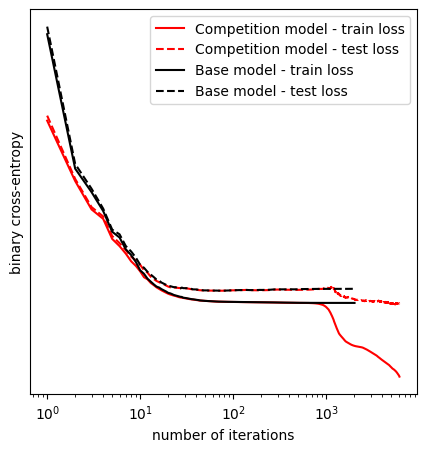

In [47]:
limit=10000

plt.figure(figsize=(5,5))

model, label, c = model3_, 'Competition model - ', 'r'

m = model
xx = pd.DataFrame()
xx['niter']=np.array(m.niter)
xx['norm']=np.array(m.R)
xx['Lval']=np.array(m.Lval)
xx['Ltrain'] = m.Ltrain
xx = xx.groupby('niter', as_index=False).min() #if multiple function evaluations at same iteration
plt.plot(xx.niter[:limit]+1, xx.Ltrain[:limit], label=label + 'train loss',c=c)
plt.plot(xx.niter[:limit]+1, xx.Lval[:limit], label=label + 'test loss',c=c,linestyle='dashed')


model, label, c = model1_, 'Base model - ', 'k'

m = model
xx = pd.DataFrame()
xx['niter']=np.array(m.niter)
xx['norm']=np.array(m.R)
xx['Lval']=np.array(m.Lval)
xx['Ltrain'] = m.Ltrain
xx = xx.groupby('niter', as_index=False).min() #if multiple function evaluations at same iteration
plt.plot(xx.niter[:limit]+1, xx.Ltrain[:limit], label=label + 'train loss',c=c)
plt.plot(xx.niter[:limit]+1, xx.Lval[:limit], label=label + 'test loss',c=c,linestyle='dashed')

plt.ylabel("binary cross-entropy")
plt.xlabel("number of iterations")
plt.xscale("log")
#plt.yscale("log")
plt.yticks([])
plt.legend()
plt.show()